### load packages

In [40]:
# make visible the only one GPU
%env CUDA_VISIBLE_DEVICES=3

env: CUDA_VISIBLE_DEVICES=3


In [41]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tqdm.autonotebook import tqdm
%matplotlib inline
from IPython import display
import pandas as pd
from data_loader_pac_gan import load_data_npz
from tensorflow.keras.layers import Dense, Reshape, Conv2DTranspose, Conv2D, Flatten, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
import os

In [42]:
print(tf.__version__)

2.14.1


### Create a fashion-MNIST dataset

In [43]:
TRAIN_BUF=17600
BATCH_SIZE=32
TEST_BUF=4400
DIMS = (28,28,1)
N_TRAIN_BATCHES =int(TRAIN_BUF/BATCH_SIZE)
N_TEST_BATCHES = int(TEST_BUF/BATCH_SIZE)

In [44]:
# load dataset
(train_images, _), (test_images, _) = load_data_npz()

# split dataset
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype(
    "float32"
) / 255.0
test_images = test_images.reshape(test_images.shape[0], 28, 28, 1).astype("float32") / 255.0

# batch datasets
train_dataset = (
    tf.data.Dataset.from_tensor_slices(train_images)
    .shuffle(TRAIN_BUF)
    .batch(BATCH_SIZE)
)
test_dataset = (
    tf.data.Dataset.from_tensor_slices(test_images)
    .shuffle(TEST_BUF)
    .batch(BATCH_SIZE)
)

x_train shape: (17600, 28, 28)
y_train shape: (17600, 28, 28)


### Define the network as tf.keras.model object

In [45]:
class WGAN(tf.keras.Model):
    """[summary]
    I used github/LynnHo/DCGAN-LSGAN-WGAN-GP-DRAGAN-Tensorflow-2/ as a reference on this.

    Extends:
        tf.keras.Model
    """

    def __init__(self, **kwargs):
        super(WGAN, self).__init__()
        self.__dict__.update(kwargs)

        self.gen = tf.keras.Sequential(self.gen)
        self.disc = tf.keras.Sequential(self.disc)

    def generate(self, z):
        return self.gen(z)

    def discriminate(self, x):
        return self.disc(x)

    def compute_loss(self, x):
        """ passes through the network and computes loss
        """
        ### pass through network
        # generating noise from a uniform distribution

        z_samp = tf.random.normal([x.shape[0], 1, 1, self.n_Z])

        # run noise through generator
        x_gen = self.generate(z_samp)
        # discriminate x and x_gen
        logits_x = self.discriminate(x)
        logits_x_gen = self.discriminate(x_gen)

        # gradient penalty
        d_regularizer = self.gradient_penalty(x, x_gen)
        ### losses
        disc_loss = (
            tf.reduce_mean(logits_x)
            - tf.reduce_mean(logits_x_gen)
            + d_regularizer * self.gradient_penalty_weight
        )

        # losses of fake with label "1"
        gen_loss = tf.reduce_mean(logits_x_gen)

        return disc_loss, gen_loss

    def compute_gradients(self, x):
        """ passes through the network and computes loss
        """
        ### pass through network
        with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
            disc_loss, gen_loss = self.compute_loss(x)

        # compute gradients
        gen_gradients = gen_tape.gradient(gen_loss, self.gen.trainable_variables)

        disc_gradients = disc_tape.gradient(disc_loss, self.disc.trainable_variables)

        return gen_gradients, disc_gradients

    def apply_gradients(self, gen_gradients, disc_gradients):

        self.gen_optimizer.apply_gradients(
            zip(gen_gradients, self.gen.trainable_variables)
        )
        self.disc_optimizer.apply_gradients(
            zip(disc_gradients, self.disc.trainable_variables)
        )

    def gradient_penalty(self, x, x_gen):
        epsilon = tf.random.uniform([x.shape[0], 1, 1, 1], 0.0, 1.0)
        x_hat = epsilon * x + (1 - epsilon) * x_gen
        with tf.GradientTape() as t:
            t.watch(x_hat)
            d_hat = self.discriminate(x_hat)
        gradients = t.gradient(d_hat, x_hat)
        ddx = tf.sqrt(tf.reduce_sum(gradients ** 2, axis=[1, 2]))
        d_regularizer = tf.reduce_mean((ddx - 1.0) ** 2)
        return d_regularizer

    @tf.function
    def train(self, train_x):
        gen_gradients, disc_gradients = self.compute_gradients(train_x)
        self.apply_gradients(gen_gradients, disc_gradients)

### Define the network architecture

In [46]:
N_Z = 1024
activation = tf.keras.layers.LeakyReLU(alpha=0.2)
l2_reg = 2.5e-5

generator = [
    tf.keras.layers.Dense(64, input_dim=N_Z, activation=activation, kernel_regularizer=l2(l2_reg)),
    tf.keras.layers.Dense(1024, activation=activation, kernel_regularizer=l2(l2_reg)),
    tf.keras.layers.Dense(12544, activation=activation, kernel_regularizer=l2(l2_reg)),
    
    tf.keras.layers.Reshape(target_shape=(7, 7, 256)),
    
    tf.keras.layers.Conv2DTranspose(
        filters=64, kernel_size=4, strides=(2, 2), padding="SAME", activation=activation, kernel_regularizer=l2(l2_reg)
    ),
    tf.keras.layers.Conv2DTranspose(
        filters=32, kernel_size=4, strides=(2, 2), padding="SAME", activation=activation, kernel_regularizer=l2(l2_reg)
    ),
    tf.keras.layers.Conv2D(
        filters=1, kernel_size=4, strides=(1, 1), padding="SAME", activation="sigmoid", kernel_regularizer=l2(l2_reg)
    ),
]

discriminator = [
    tf.keras.layers.InputLayer(input_shape=DIMS),
    tf.keras.layers.Conv2D(
        filters=32, kernel_size=4, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Conv2D(
        filters=64, kernel_size=4, strides=(2, 2), activation="relu"
    ),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(units=1, activation="linear"),
]

### Create Model

In [47]:
# optimizers
gen_optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.5)
disc_optimizer = tf.keras.optimizers.Adam(0.001, beta_1=0.5)
# model
model = WGAN(
    gen = generator,
    disc = discriminator,
    gen_optimizer = gen_optimizer,
    disc_optimizer = disc_optimizer,
    n_Z = N_Z,
    gradient_penalty_weight = 1.0
)

### Train the model

In [48]:
# exampled data for plotting results
def plot_reconstruction(model, nex=8, zm=2):
    samples = model.generate(tf.random.normal(shape=(BATCH_SIZE, N_Z)))
    fig, axs = plt.subplots(ncols=nex, nrows=1, figsize=(zm * nex, zm))
    for axi in range(nex):
        axs[axi].matshow(
                    samples.numpy()[axi].squeeze(), cmap=plt.cm.Greys, vmin=0, vmax=1
                )
        axs[axi].axis('off')
    plt.show()

In [49]:
# a pandas dataframe to save the loss information to
losses = pd.DataFrame(columns = ['disc_loss', 'gen_loss'])

In [ ]:
current_dir = os.path.dirname(os.path.abspath(__file__))
output_images_dir = os.path.join(current_dir, 'output_images')

def save_generated_images(epoch, generator, batch, examples=1, random_dim=1024):
    noise = np.random.normal(0, 1, (examples, random_dim))

    generated_images = generator.predict(noise)

    # Reescalar para o intervalo [0, 255]
    generated_images = 0.5 * generated_images + 0.5
    generated_images = (generated_images * 255).astype(np.uint8)
    # generator.save("generator_model.keras")

    if not os.path.exists(f"{output_images_dir}/generated_images_{epoch}"):
        os.makedirs(f"{output_images_dir}/generated_images_{epoch}")

    for i in range(examples):
        # Juntar todas as imagens geradas em uma única imagem
        image = generated_images[i, :, :, :]
        image = np.reshape(image, [28, 28])
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        
    # Salvar imagem
    plt.savefig(f"{output_images_dir}/generated_images_{epoch}/generated_image_{batch}.png")

Epoch: 133 | disc_loss: -0.09253714978694916 | gen_loss: 0.5478312969207764


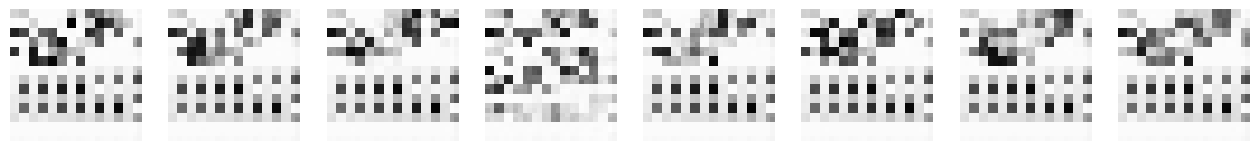

 15%|█▍        | 278/1875 [00:06<00:46, 34.35it/s]

In [50]:
n_epochs = 200
for epoch in range(n_epochs):
    # train
    for batch, train_x in tqdm(
        zip(range(N_TRAIN_BATCHES), train_dataset), total=N_TRAIN_BATCHES
    ):
        model.train(train_x)
    # test on holdout
    loss = []
    for batch, test_x in tqdm(
        zip(range(N_TEST_BATCHES), test_dataset), total=N_TEST_BATCHES
    ):
        loss.append(model.compute_loss(train_x))
    losses.loc[len(losses)] = np.mean(loss, axis=0)
    # plot results
    display.clear_output()
    print(
        "Epoch: {} | disc_loss: {} | gen_loss: {}".format(
            epoch, losses.disc_loss.values[-1], losses.gen_loss.values[-1]
        )
        
    )
    save_generated_images(epoch, model.gen, batch)
    model.save_weights("model_weights.keras")
    plot_reconstruction(model)

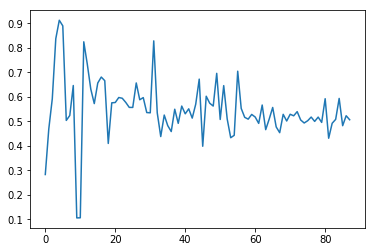

In [ ]:
plt.plot(losses.gen_loss.values)

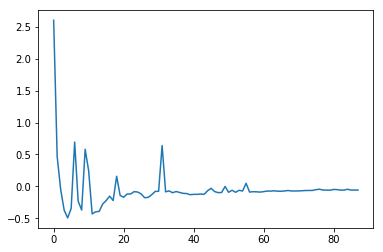

In [ ]:
plt.plot(losses.disc_loss.values)